In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import json
import base64
import time
import warnings

# Use this line to suppress warnings
warnings.filterwarnings('ignore')


client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')

In [2]:
# Function to get an access token from Spotify
def get_spotify_token(client_id, client_secret):
    client_creds = f"{client_id}:{client_secret}"
    # client_creds_b64 = base64.b64encode(client_creds.encode()).decode()  # Ensure this is decoded back to string
    client_creds_b64 = "ZWUxYzg1OWZhMTgwNDIyMzhiODIwM2IxMWNlOTMzMjU6ZDUwMjgxOTM2OWJhNDVjYWExYWJlYWRmYjIxYTc3YWU="   # TODO

    url = 'https://accounts.spotify.com/api/token'
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {client_creds_b64}'
    }
    payload = {'grant_type': 'client_credentials'}

    response = requests.post(url, headers=headers, data=payload)
    if response.status_code != 200:
        print("Failed to fetch token:")
        print("Status Code:", response.status_code)
        print("Response:", response.text)
    # else:
    #     print(response.json())
    return response.json().get('access_token')

token = get_spotify_token(client_id, client_secret)
token

'BQBO50NkuMnEfGsnBV3Mo7vK63jQpHHoo24JuFuHOm1plcuo4g6YVzUdCerdGum568W5fyKMEHcJwCqDwMT0uJrGaZDlmajq6oahTvQq_VNO1Qaq5fA'

## Data Collection

Gathering information from various sources.

I am using the Spotify Million Playlist dataset and the Spotify Web API to get the following features every song - 

1. track_id
2. artist_name
3. track_name
4. album_name
5. acousticness
6. danceability
7. energy
8. instrumentalness
9. liveness
10. loudness
11. speechiness
12. tempo
13. valence

I am building a dataframe that will be used to further build and optimize the machine learning models.


In [3]:
def safe_request(url, headers, retries=5, backoff_factor=2):
    """ Helper function to handle requests with retry logic including backoff """
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)  # Adding a timeout
            response.raise_for_status()
            return response
        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:
                retry_after = int(response.headers.get('retry-after', 60))
                print(f"Rate limit exceeded, retrying in {retry_after} seconds")
                time.sleep(retry_after)
            else:
                print(f"HTTPError occurred: {e}")
                if i == retries - 1:
                    raise
                time.sleep(backoff_factor * (2 ** i))
        except requests.exceptions.RequestException as e:
            print(f"RequestException occurred: {e}")
            if i == retries - 1:
                raise
            time.sleep(backoff_factor * (2 ** i))

In [4]:
def get_artist_genres(artist_ids, token):
    """ Fetch genres for a list of artist IDs from Spotify """
    artist_ids = ','.join(artist_ids)  # Convert list of artist IDs to a comma-separated string
    url = f"https://api.spotify.com/v1/artists?ids={artist_ids}"
    headers = {'Authorization': f'Bearer {token}'}
    response = safe_request(url, headers)
    artists_details = response.json()

    genres = []
    for artist in artists_details['artists']:
        if artist:
            genres.extend(artist.get('genres', []))
    return list(set(genres))  # Return unique genres


def fetch_track_data(spotify_token, track_ids):
    headers = {'Authorization': f'Bearer {spotify_token}'}
    track_url = f"https://api.spotify.com/v1/tracks?ids={','.join(track_ids)}"
    features_url = f"https://api.spotify.com/v1/audio-features?ids={','.join(track_ids)}"

    track_response = safe_request(track_url, headers)
    features_response = safe_request(features_url, headers)

    track_details = track_response.json()
    features_details = features_response.json()

    track_data = []
    for i, track in enumerate(track_details['tracks']):
        if track and features_details['audio_features'][i]:
            artist_ids = [artist['id'] for artist in track['artists']]
            genres = get_artist_genres(artist_ids, spotify_token)
            feature = features_details['audio_features'][i]
            track_data.append({
                'track_id': track['id'],
                'artist_name': track['artists'][0]['name'],
                'track_name': track['name'],
                'album_name': track['album']['name'],
                'genres': genres,
                'acousticness': feature.get('acousticness', 0),
                'danceability': feature.get('danceability', 0),
                'energy': feature.get('energy', 0),
                'instrumentalness': feature.get('instrumentalness', 0),
                'liveness': feature.get('liveness', 0),
                'loudness': feature.get('loudness', 0),
                'speechiness': feature.get('speechiness', 0),
                'tempo': feature.get('tempo', 0),
                'valence': feature.get('valence', 0)
            })
    return track_data

In [7]:
from pathlib import Path

def process_playlists(spotify_token, path, max_songs=200):
    batch_size = 50
    data = []
    current_track_id_list = []
    unique_tracks = set()
    filenames = os.listdir(path)
    # filenames = Path(path)

    for filename in sorted(filenames):
    # for filename in filenames.iterdir():
        if len(data) == max_songs:
            break
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            with open(os.path.join(path, filename)) as f:
                mpd_slice = json.load(f)

            for playlist in mpd_slice["playlists"]:
                if len(data) == max_songs:
                    break
                for track in playlist['tracks']:
                    track_id = track['track_uri'].split(':')[-1]
                    if track_id not in unique_tracks and len(current_track_id_list) < batch_size and (len(current_track_id_list) + len(data)) < max_songs:
                        current_track_id_list.append(track_id)
                    else:
                        data.extend(fetch_track_data(spotify_token, current_track_id_list))
                        current_track_id_list = []
                    if len(data) == max_songs:
                        break
    return pd.DataFrame(data)

In [11]:
data = process_playlists(token, "/Users/noopurparagphadkar/Downloads/spotify_million_playlist_dataset/data/")
data.head()

,track_id,artist_name,track_name,album_name,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,"[rap, neo soul, hip pop, nyc rap, dance pop, v...",0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.810
1,6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,"[pop, dance pop]",0.02490,0.774,0.838,0.025000,0.2420,-3.914,0.1140,143.040,0.924
2,0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love (feat. Jay-Z),Dangerously In Love (Alben für die Ewigkeit),"[rap, east coast hip hop, gangster rap, r&b, h...",0.00238,0.664,0.758,0.000000,0.0598,-6.583,0.2100,99.259,0.701
3,1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,Justified,"[pop, dance pop]",0.20100,0.892,0.714,0.000234,0.0521,-6.055,0.1410,100.972,0.817
4,1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,Hot Shot (International Version #2),"[dance pop, reggae fusion, pop rap]",0.05610,0.853,0.606,0.000000,0.3130,-4.596,0.0713,94.759,0.654


## Data Preprocessing

Cleaning and organizing raw data into a suitable format for analysis.

I am checking for any missing or null values in the dataset.

#### Column (Feature) Description
1. Track ID: A unique identifier for the track, typically used internally and for fetching additional data via APIs.
2. Artist Name: The name of the artist who performed the track. This can be used for deriving insights based on artist-specific trends or popularity.
3. Track Name: The title of the track. This can sometimes give insights into the content or style of the music.
4. Album Name: The name of the album on which the track appears. Album names can help in identifying specific albums that are iconic or significant within a genre.
5. Genres: While not directly available as mentioned, this can be derived from artist information. This is the target feature for your classification model and categorizes tracks into genres like rock, pop, jazz, etc.
6. Acousticness: A measure from 0.0 to 1.0 indicating how acoustic a track is. Tracks with high acousticness are more likely to be acoustic.
7. Danceability: This describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value closer to 1.0 indicates a higher suitability for dancing.
8. Energy: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity. Energetic tracks feel fast, loud, and noisy.
9. Instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
10. Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
11. Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
12. Speechiness: Speechiness detects the presence of spoken words in a track. A more speech-like track has a closer speechiness value to 1.0, while tracks with more music and less talk have lower values.
13. Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
14. Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry).

In [12]:
# Get a concise summary of the dataframe
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          200 non-null    object 
 1   artist_name       200 non-null    object 
 2   track_name        200 non-null    object 
 3   album_name        200 non-null    object 
 4   genres            200 non-null    object 
 5   acousticness      200 non-null    float64
 6   danceability      200 non-null    float64
 7   energy            200 non-null    float64
 8   instrumentalness  200 non-null    float64
 9   liveness          200 non-null    float64
 10  loudness          200 non-null    float64
 11  speechiness       200 non-null    float64
 12  tempo             200 non-null    float64
 13  valence           200 non-null    float64
dtypes: float64(9), object(5)
memory usage: 22.0+ KB
None


In [13]:
# Describe the data to get basic statistical details like percentile, mean, std etc.
print(data.describe())

       acousticness  danceability      energy  instrumentalness    liveness  \
count    200.000000    200.000000  200.000000        200.000000  200.000000   
mean       0.208009      0.607874    0.696731          0.087913    0.182335   
std        0.254307      0.157605    0.201233          0.246285    0.136186   
min        0.000010      0.084900    0.068200          0.000000    0.026800   
25%        0.008287      0.502500    0.597250          0.000000    0.089250   
50%        0.091350      0.627000    0.725000          0.000002    0.132000   
75%        0.315250      0.726250    0.851500          0.002423    0.247500   
max        0.988000      0.938000    0.976000          0.991000    0.869000   

         loudness  speechiness       tempo     valence  
count  200.000000   200.000000  200.000000  200.000000  
mean    -6.537635     0.094473  121.003925    0.545471  
std      3.617437     0.094881   28.920638    0.218273  
min    -29.917000     0.025000   48.973000    0.038500  
25%

In [14]:
data.isnull().sum()

track_id            0
artist_name         0
track_name          0
album_name          0
genres              0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

There are no missing values in the dataset.

In [15]:
data.dtypes

track_id             object
artist_name          object
track_name           object
album_name           object
genres               object
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
dtype: object

In [16]:
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

Categorical columns: Index(['track_id', 'artist_name', 'track_name', 'album_name', 'genres'], dtype='object')


In [18]:
# Using pandas to explode and then find unique values
unique_genres = pd.Series(data['genres'].sum()).unique()

# Print results
print(f'Number of unique genres: {len(unique_genres)}')
print(f'Unique genres: {unique_genres}')

Number of unique genres: 180
Unique genres: ['rap' 'neo soul' 'hip pop' 'nyc rap' 'dance pop' 'virginia hip hop' 'r&b'
 'hip hop' 'urban contemporary' 'pop' 'pop rap' 'east coast hip hop'
 'gangster rap' 'reggae fusion' 'old school atlanta hip hop'
 'contemporary r&b' 'south carolina hip hop' 'dirty south rap'
 'atl hip hop' 'southern hip hop' 'trap' 'crunk' 'girl group'
 'canadian pop' 'canadian latin' 'post-teen pop' 'candy pop'
 'harlem hip hop' 'houston rap' 'permanent wave' 'new wave pop' 'lilith'
 'pop rock' 'singer-songwriter' 'pop punk' 'neon pop punk'
 'texas pop punk' 'boy band' 'pixie' 'trap queen' 'europop' 'eurodance'
 'melbourne bounce international' 'german techno' 'indietronica'
 'escape room' 'new rave' 'alternative rock' 'modern rock' 'dance rock'
 'rock' 'punk' 'socal pop punk' 'alternative metal' 'post-grunge'
 'neo mellow' 'piano rock' 'glam metal' 'hard rock' 'soft rock'
 'album rock' 'scorecore' 'theme' 'british soundtrack' 'orchestra'
 'british orchestra' 'show 

Given the extensive list of 180 unique genres, categorizing them into broader, major genre categories can significantly simplify the genre classification model and improve its performance, especially given issues like data sparsity and class imbalance.

#### Major Genre Categories and Their Specific Genres:

1. **Pop**
   - Includes: 'dance pop', 'pop', 'pop rap', 'post-teen pop', 'candy pop', 'europop', 'canadian pop', 'ukrainian classical piano', 'nyc pop', 'indie poptimism', 'electropop', 'shimmer pop', 'k-pop', 'k-pop boy group', 'k-pop girl group'

2. **Hip Hop/Rap**
   - Includes: 'rap', 'hip pop', 'nyc rap', 'virginia hip hop', 'hip hop', 'east coast hip hop', 'gangster rap', 'south carolina hip hop', 'dirty south rap', 'atl hip hop', 'southern hip hop', 'trap', 'crunk', 'harlem hip hop', 'houston rap', 'k-rap', 'canadian trap', 'ottawa rap', 'dark trap', 'canadian hip hop', 'underground hip hop', 'aesthetic rap', 'cloud rap'

3. **Rock**
   - Includes: 'permanent wave', 'new wave pop', 'pop rock', 'singer-songwriter', 'alternative rock', 'modern rock', 'dance rock', 'rock', 'punk', 'socal pop punk', 'alternative metal', 'post-grunge', 'neo mellow', 'piano rock', 'glam metal', 'hard rock', 'soft rock', 'album rock', 'german rock', 'german hard rock', 'classic rock', 'british invasion', 'mellow gold', 'yacht rock', 'progressive rock', 'heartland rock', 'glam rock', 'swamp rock', 'country rock', 'garage rock', 'modern alternative rock', 'alternative pop rock', 'indie rock', 'modern power pop', 'washington indie', 'dance-punk', 'alternative dance', 'neo-synthpop', 'countrygaze', 'alabama indie', 'baroque pop', 'new weird america', 'garage pop', 'nashville indie', 'philly indie', 'modern folk rock', 'roots rock', 'melancholia', 'louisville indie', 'jam band', 'stomp and holler'

4. **Electronic/Dance**
   - Includes: 'eurodance', 'melbourne bounce international', 'german techno', 'indietronica', 'escape room', 'new rave', 'europop'

5. **R&B/Soul**
   - Includes: 'neo soul', 'urban contemporary', 'r&b', 'contemporary r&b', 'soul', 'motown', 'funk', 'disco'

6. **Metal**
   - Includes: 'alternative metal', 'nu metal', 'opera metal', 'finnish metal', 'symphonic metal', 'gothic metal', 'finnish power metal', 'fantasy metal', 'power metal', 'gothic symphonic metal', 'canadian metal'

7. **Jazz/Blues**
   - Includes: 'vocal jazz', 'smooth jazz', 'blues', 'soul blues', 'jazz blues', 'swing'

8. **Classical/Orchestral**
   - Includes: 'scorecore', 'theme', 'british soundtrack', 'orchestra', 'british orchestra', 'radio symphony', 'late romantic era', 'classical', 'symfonicky orchestr', 'french romanticism', 'nordic orchestra'

9. **Country/Folk**
   - Includes: 'country', 'modern country rock', 'country road', 'folk', 'folk rock', 'indie folk', 'new americana'

10. **Reggae/World**
    - Includes: 'reggae', 'reggae fusion', 'dancehall', 'ska', 'dub', 'world', 'afrobeat', 'afropop'

11. **Indie/Alternative**
    - Includes: 'indie pop', 'indie rock', 'indie folk', 'alternative rock', 'garage rock', 'psychedelic rock', 'experimental rock', 'art rock', 'krautrock', 'post-punk', 'shoegaze', 'dream pop'

This categorization clusters genres into broader groups that reflect their musical characteristics and heritage. This should make the model simpler and potentially more robust by reducing the complexity and dealing with fewer classes. Each category includes genres that share similar musical styles

In [46]:
categorization = {
   'Pop': ['dance pop', 'pop', 'pop rap', 'post-teen pop', 'candy pop', 'europop', 'canadian pop', 'ukrainian classical piano', 'nyc pop', 'indie poptimism', 'electropop', 'shimmer pop', 'k-pop', 'k-pop boy group', 'k-pop girl group'],
   'Hip Hop/Rap': ['rap', 'hip pop', 'nyc rap', 'virginia hip hop', 'hip hop', 'east coast hip hop', 'gangster rap', 'south carolina hip hop', 'dirty south rap', 'atl hip hop', 'southern hip hop', 'trap', 'crunk', 'harlem hip hop', 'houston rap', 'k-rap', 'canadian trap', 'ottawa rap', 'dark trap', 'canadian hip hop', 'underground hip hop', 'aesthetic rap', 'cloud rap'],
   'Rock': ['permanent wave', 'new wave pop', 'pop rock', 'singer-songwriter', 'alternative rock', 'modern rock', 'dance rock', 'rock', 'punk', 'socal pop punk', 'alternative metal', 'post-grunge', 'neo mellow', 'piano rock', 'glam metal', 'hard rock', 'soft rock', 'album rock', 'german rock', 'german hard rock', 'classic rock', 'british invasion', 'mellow gold', 'yacht rock', 'progressive rock', 'heartland rock', 'glam rock', 'swamp rock', 'country rock', 'garage rock', 'modern alternative rock', 'alternative pop rock', 'indie rock', 'modern power pop', 'washington indie', 'dance-punk', 'alternative dance', 'neo-synthpop', 'countrygaze', 'alabama indie', 'baroque pop', 'new weird america', 'garage pop', 'nashville indie', 'philly indie', 'modern folk rock', 'roots rock', 'melancholia', 'louisville indie', 'jam band', 'stomp and holler'],
   'Electronic/Dance': ['eurodance', 'melbourne bounce international', 'german techno', 'indietronica', 'escape room', 'new rave', 'europop'],
   'R&B/Soul': ['neo soul', 'urban contemporary', 'r&b', 'contemporary r&b', 'soul', 'motown', 'funk', 'disco'],
   'Metal': ['alternative metal', 'nu metal', 'opera metal', 'finnish metal', 'symphonic metal', 'gothic metal', 'finnish power metal', 'fantasy metal', 'power metal', 'gothic symphonic metal', 'canadian metal'],
   'Jazz/Blues': ['vocal jazz', 'smooth jazz', 'blues', 'soul blues', 'jazz blues', 'swing'],
   'Classical/Orchestral': ['scorecore', 'theme', 'british soundtrack', 'orchestra', 'british orchestra', 'radio symphony', 'late romantic era', 'classical', 'symfonicky orchestr', 'french romanticism', 'nordic orchestra'],
   'Country/Folk': ['country', 'modern country rock', 'country road', 'folk', 'folk rock', 'indie folk', 'new americana'],
   'Reggae/World': ['reggae', 'reggae fusion', 'dancehall', 'ska', 'dub', 'world', 'afrobeat', 'afropop'],
   'Indie/Alternative': ['indie pop', 'indie rock', 'indie folk', 'alternative rock', 'garage rock', 'psychedelic rock', 'experimental rock', 'art rock', 'krautrock', 'post-punk', 'shoegaze', 'dream pop']
}

# Create a reverse lookup dictionary for genre mapping
reverse_categorization = {}
for major, subs in categorization.items():
    for sub in subs:
        reverse_categorization[sub] = major

print(reverse_categorization)

{'dance pop': 'Pop', 'pop': 'Pop', 'pop rap': 'Pop', 'post-teen pop': 'Pop', 'candy pop': 'Pop', 'europop': 'Electronic/Dance', 'canadian pop': 'Pop', 'ukrainian classical piano': 'Pop', 'nyc pop': 'Pop', 'indie poptimism': 'Pop', 'electropop': 'Pop', 'shimmer pop': 'Pop', 'k-pop': 'Pop', 'k-pop boy group': 'Pop', 'k-pop girl group': 'Pop', 'rap': 'Hip Hop/Rap', 'hip pop': 'Hip Hop/Rap', 'nyc rap': 'Hip Hop/Rap', 'virginia hip hop': 'Hip Hop/Rap', 'hip hop': 'Hip Hop/Rap', 'east coast hip hop': 'Hip Hop/Rap', 'gangster rap': 'Hip Hop/Rap', 'south carolina hip hop': 'Hip Hop/Rap', 'dirty south rap': 'Hip Hop/Rap', 'atl hip hop': 'Hip Hop/Rap', 'southern hip hop': 'Hip Hop/Rap', 'trap': 'Hip Hop/Rap', 'crunk': 'Hip Hop/Rap', 'harlem hip hop': 'Hip Hop/Rap', 'houston rap': 'Hip Hop/Rap', 'k-rap': 'Hip Hop/Rap', 'canadian trap': 'Hip Hop/Rap', 'ottawa rap': 'Hip Hop/Rap', 'dark trap': 'Hip Hop/Rap', 'canadian hip hop': 'Hip Hop/Rap', 'underground hip hop': 'Hip Hop/Rap', 'aesthetic rap': '

In [55]:
# Function to map sub-genres to major genres
def map_genres_to_major(genre_list):
    major_genres = set()  # Use a set to avoid duplicates
    for genre in genre_list:
        if genre in reverse_categorization:
            major_genres.add(reverse_categorization[genre])
    return list(major_genres)

# Apply the function to the genres column
data['major_genres'] = data['genres'].apply(map_genres_to_major)

# Drop the 'genres' column
data = data.drop('genres', axis=1)

# Rename the 'major_genres' column to 'genres'
data = data.rename(columns={'major_genres': 'genres'})

data.head()

,track_id,artist_name,track_name,album_name,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genres
0,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.810,"[Pop, R&B/Soul, Hip Hop/Rap]"
1,6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,0.02490,0.774,0.838,0.025000,0.2420,-3.914,0.1140,143.040,0.924,[Pop]
2,0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love (feat. Jay-Z),Dangerously In Love (Alben für die Ewigkeit),0.00238,0.664,0.758,0.000000,0.0598,-6.583,0.2100,99.259,0.701,"[Pop, R&B/Soul, Hip Hop/Rap]"
3,1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,Justified,0.20100,0.892,0.714,0.000234,0.0521,-6.055,0.1410,100.972,0.817,[Pop]
4,1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,Hot Shot (International Version #2),0.05610,0.853,0.606,0.000000,0.3130,-4.596,0.0713,94.759,0.654,"[Reggae/World, Pop]"


### One Hot Encoding

Since hte target variable is genres which contains list of strings, We will explode the DataFrame without resetting the index to create new rows, one for each genre.

In [110]:
# Explode the 'genres' list into rows while preserving the original index
data_exploded = data.explode('genres')

# Apply one-hot encoding to the exploded genres
genres_encoded = pd.get_dummies(data_exploded['genres'], prefix='genre')

# Ensure you group by the index of the exploded DataFrame which should match the original data
# Here, you should use the index from data_exploded as the groupby key
data_final = data.join(genres_encoded.groupby(data_exploded.index).sum())
data_final

,track_id,artist_name,track_name,album_name,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,genre_Classical/Orchestral,genre_Electronic/Dance,genre_Hip Hop/Rap,genre_Indie/Alternative,genre_Jazz/Blues,genre_Metal,genre_Pop,genre_R&B/Soul,genre_Reggae/World,genre_Rock
0,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,0.03110,0.904,0.813,0.006970,0.0471,-7.105,...,0,0,1,0,0,0,1,1,0,0
1,6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,0.02490,0.774,0.838,0.025000,0.2420,-3.914,...,0,0,0,0,0,0,1,0,0,0
2,0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love (feat. Jay-Z),Dangerously In Love (Alben für die Ewigkeit),0.00238,0.664,0.758,0.000000,0.0598,-6.583,...,0,0,1,0,0,0,1,1,0,0
3,1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,Justified,0.20100,0.892,0.714,0.000234,0.0521,-6.055,...,0,0,0,0,0,0,1,0,0,0
4,1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,Hot Shot (International Version #2),0.05610,0.853,0.606,0.000000,0.3130,-4.596,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5XkTer2cNrqMAAYOiqwdJt,bo en,Miss You,Pale Machine,0.23400,0.743,0.672,0.000016,0.8690,-9.135,...,0,0,0,0,0,0,0,0,0,0
196,5hs2nY40aeqM0mpP8SBOon,bo en,Money Won't Pay,Pale Machine Expansion Pack Singles,0.21800,0.784,0.715,0.000000,0.4150,-5.675,...,0,0,0,0,0,0,0,0,0,0
197,0tOyrixMQ17NUznPIxYtVD,bo en,I'll Fall,Pale Machine Expansion Pack Singles,0.52700,0.823,0.460,0.000002,0.0548,-8.114,...,0,0,0,0,0,0,0,0,0,0
198,3GhsBdS9ulPK3KCdwHRPhG,Cigarettes After Sex,Nothing's Gonna Hurt You Baby,I.,0.27200,0.509,0.331,0.136000,0.1140,-14.083,...,0,0,0,1,0,0,0,0,0,0


## Exploratory Data Analysis (EDA)

Analyzing the data to summarize main characteristics and visualize trends.

Use of histograms or box plots help to understand the distribution of numerical features and identify outliers.

### Understanding the Target Variable

Since the ultimate goal is to build a genre classification model, 'genres' column is the target variable.

/var/folders/fd/h760mgjd02s71r2z__34kzxm0000gn/T/ipykernel_26784/397600770.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='viridis')


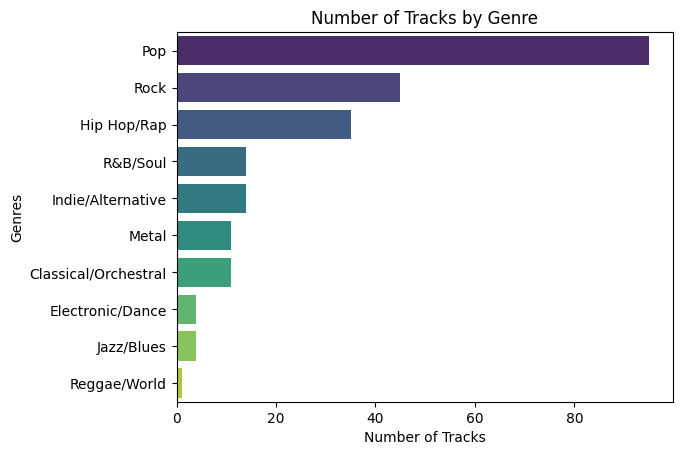

In [64]:
# Explode the DataFrame so each genre gets its own row
genre_counts = data['genres'].explode().value_counts()

plt.figure()
sns.barplot(y=genre_counts.index, x=genre_counts.values, palette='viridis')
plt.title('Number of Tracks by Genre')
plt.xlabel('Number of Tracks')
plt.ylabel('Genres')
plt.show()

The bar chart shows the distribution of tracks across various genres. From this chart, it's evident that there is an imbalance in the dataset:

1. Pop has the highest number of tracks, making it the most represented genre in the dataset.
2. Rock and Hip Hop/Rap also have a significant number of tracks, although less than Pop.
3. R&B/Soul, Indie/Alternative, Metal, and Classical/Orchestral have a moderate representation.
4. Electronic/Dance, Jazz/Blues, and Reggae/World are the least represented in this dataset, with notably fewer tracks compared to the rest.

### Exploring Audio Features Distributions

Investigating the distributions of the various audio features to understand their characteristics.

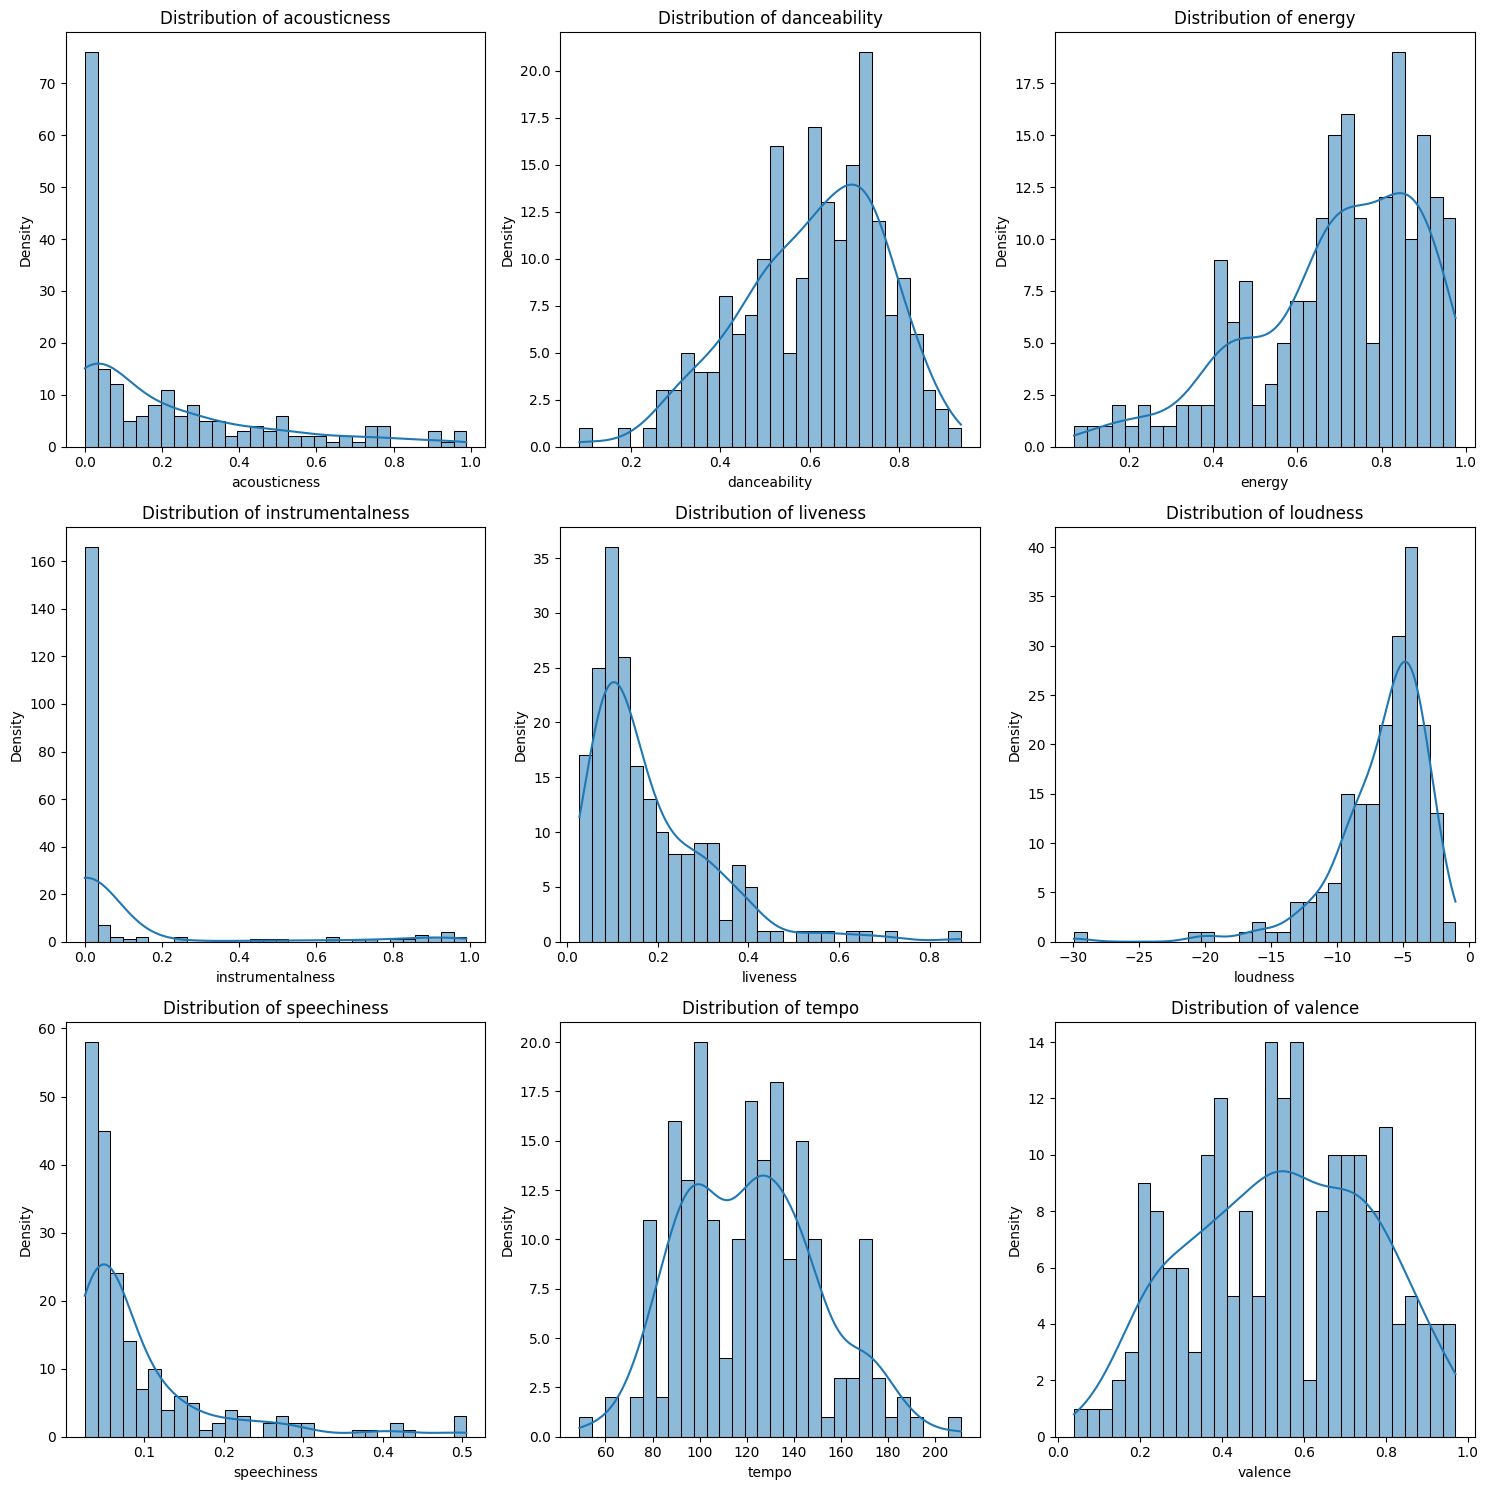

In [101]:
# Selecting the audio feature columns, assuming they are the same as in your uploaded dataframe structure
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# Determine the number of rows needed for a 3-column grid
n_rows = int(np.ceil(len(audio_features) / 3))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the features and plot the histograms
for i, feature in enumerate(audio_features):
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# Adjust the layout
plt.tight_layout()
plt.show()

### Audio Features vs Genres

Outliers in the features, they could skew the performance of the classification model.

In [106]:
# Exploding the 'genres' column for ease of plotting
data_exploded = data.explode('genres').reset_index(drop=True)
data_exploded

,track_id,artist_name,track_name,album_name,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genres
0,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.8100,Pop
1,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.8100,R&B/Soul
2,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.8100,Hip Hop/Rap
3,6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,0.02490,0.774,0.838,0.025000,0.2420,-3.914,0.1140,143.040,0.9240,Pop
4,0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love (feat. Jay-Z),Dangerously In Love (Alben für die Ewigkeit),0.00238,0.664,0.758,0.000000,0.0598,-6.583,0.2100,99.259,0.7010,Pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,5XkTer2cNrqMAAYOiqwdJt,bo en,Miss You,Pale Machine,0.23400,0.743,0.672,0.000016,0.8690,-9.135,0.2140,115.977,0.5060,NaN
260,5hs2nY40aeqM0mpP8SBOon,bo en,Money Won't Pay,Pale Machine Expansion Pack Singles,0.21800,0.784,0.715,0.000000,0.4150,-5.675,0.0664,119.995,0.8460,NaN
261,0tOyrixMQ17NUznPIxYtVD,bo en,I'll Fall,Pale Machine Expansion Pack Singles,0.52700,0.823,0.460,0.000002,0.0548,-8.114,0.1140,119.935,0.5220,NaN
262,3GhsBdS9ulPK3KCdwHRPhG,Cigarettes After Sex,Nothing's Gonna Hurt You Baby,I.,0.27200,0.509,0.331,0.136000,0.1140,-14.083,0.0267,96.848,0.0957,Indie/Alternative


In [108]:
categorization.keys()

dict_keys(['Pop', 'Hip Hop/Rap', 'Rock', 'Electronic/Dance', 'R&B/Soul', 'Metal', 'Jazz/Blues', 'Classical/Orchestral', 'Country/Folk', 'Reggae/World', 'Indie/Alternative'])

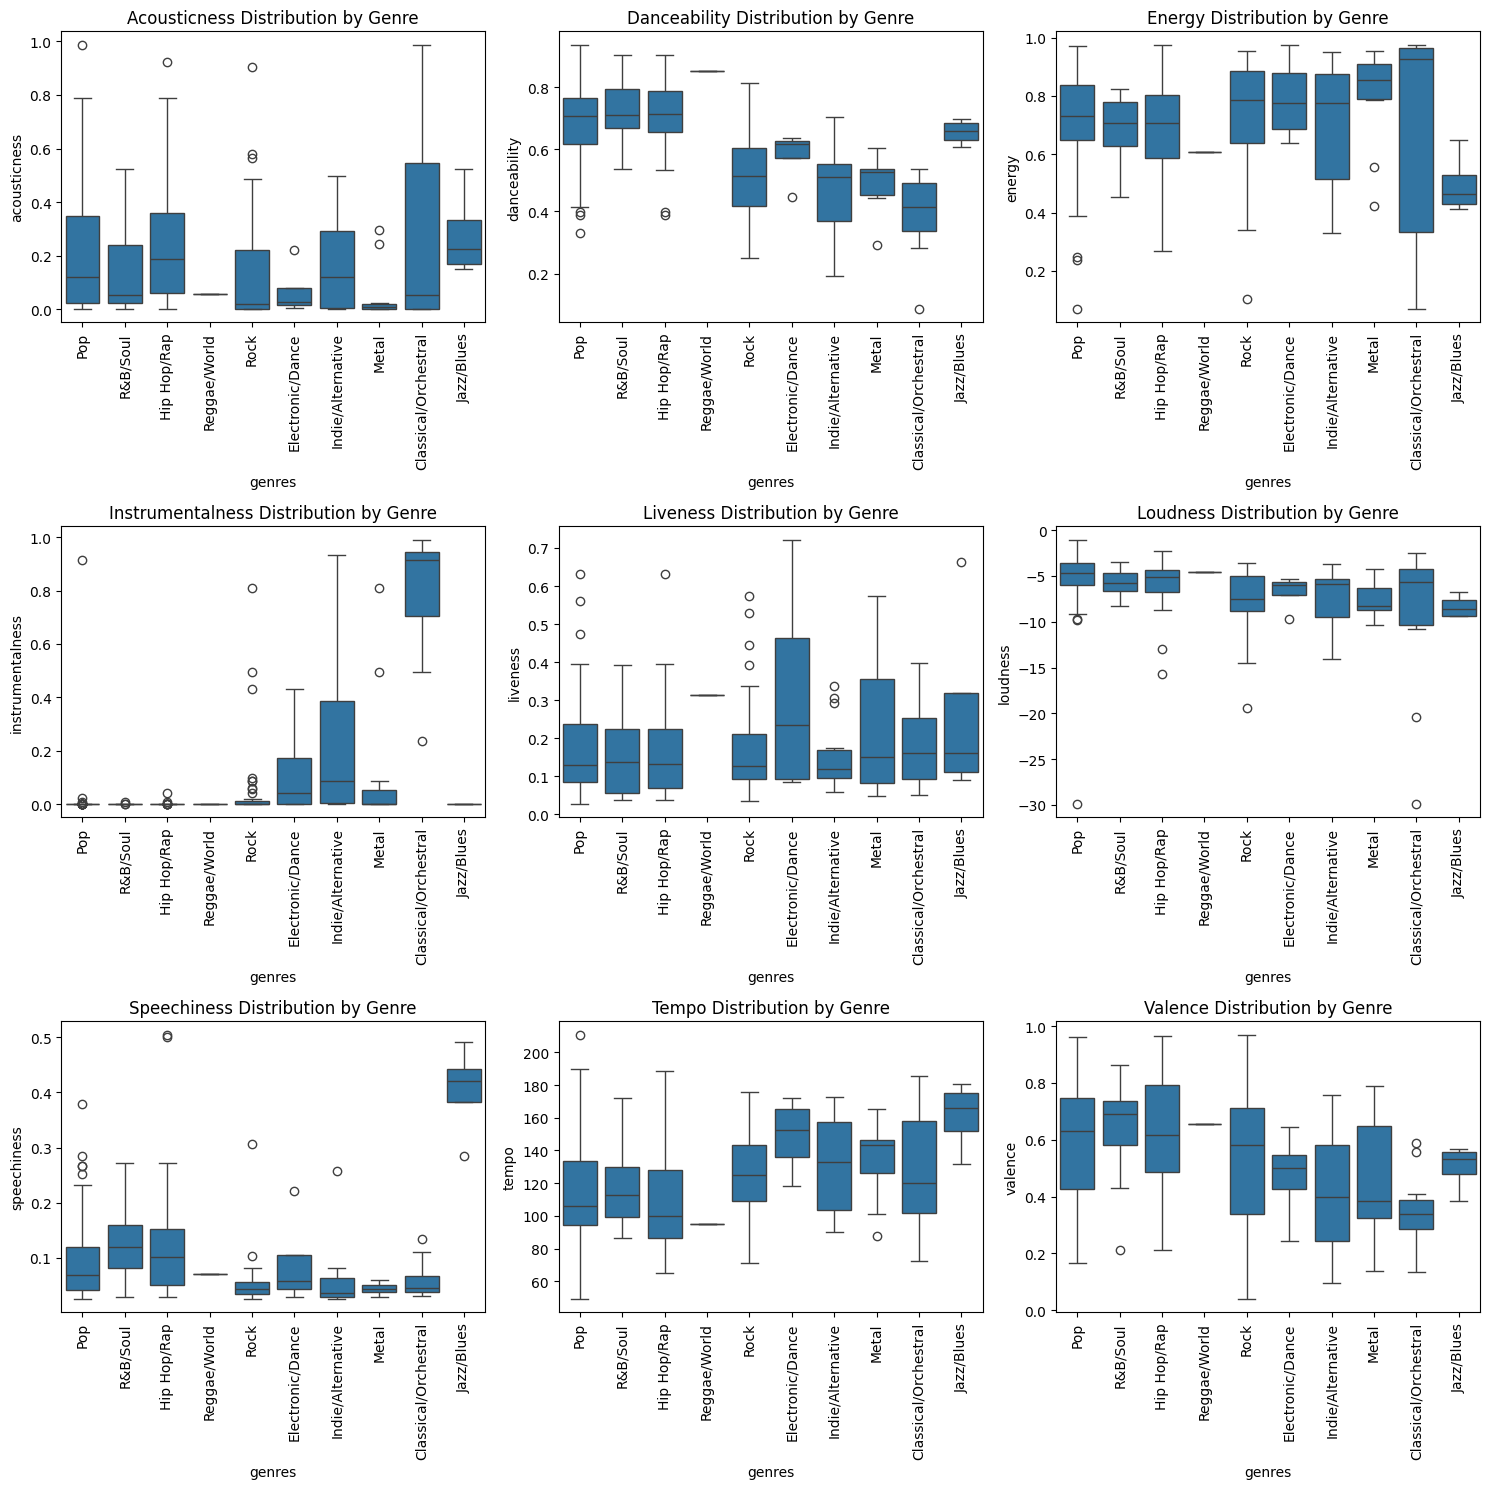

In [107]:
# Number of rows based on the number of features
n_rows = int(np.ceil(len(audio_features) / 3))

# Set up the matplotlib figure
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the array to make iteration easier

for i, feature in enumerate(audio_features):
    sns.boxplot(x='genres', y=feature, data=data_exploded, ax=axes[i])
    axes[i].set_title(f'{feature.capitalize()} Distribution by Genre')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_ylabel(feature)

# Adjust the layout
plt.tight_layout()
plt.show()

### Feature Correlations

Understanding how features are correlated with each other can provide insights into which features are more important and if there are any redundant features.

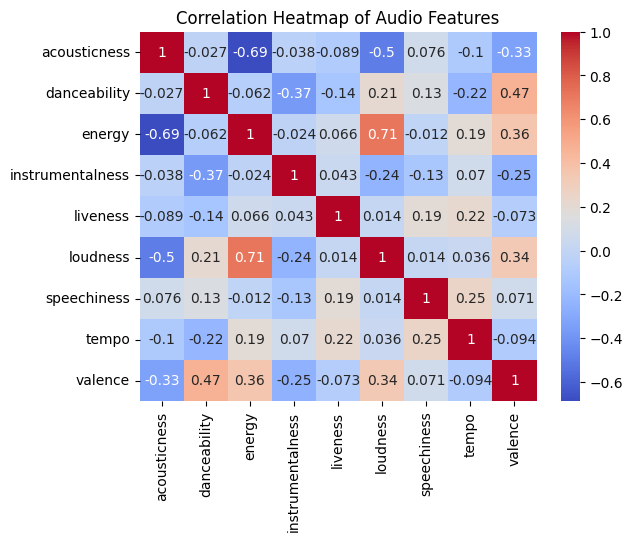

In [103]:
# Correlation heatmap
correlation_matrix = data[audio_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Audio Features')
plt.show()

### Pairwise Relationships

A pair plot visualizes the pairwise relationships between features and how they are distributed across genres.

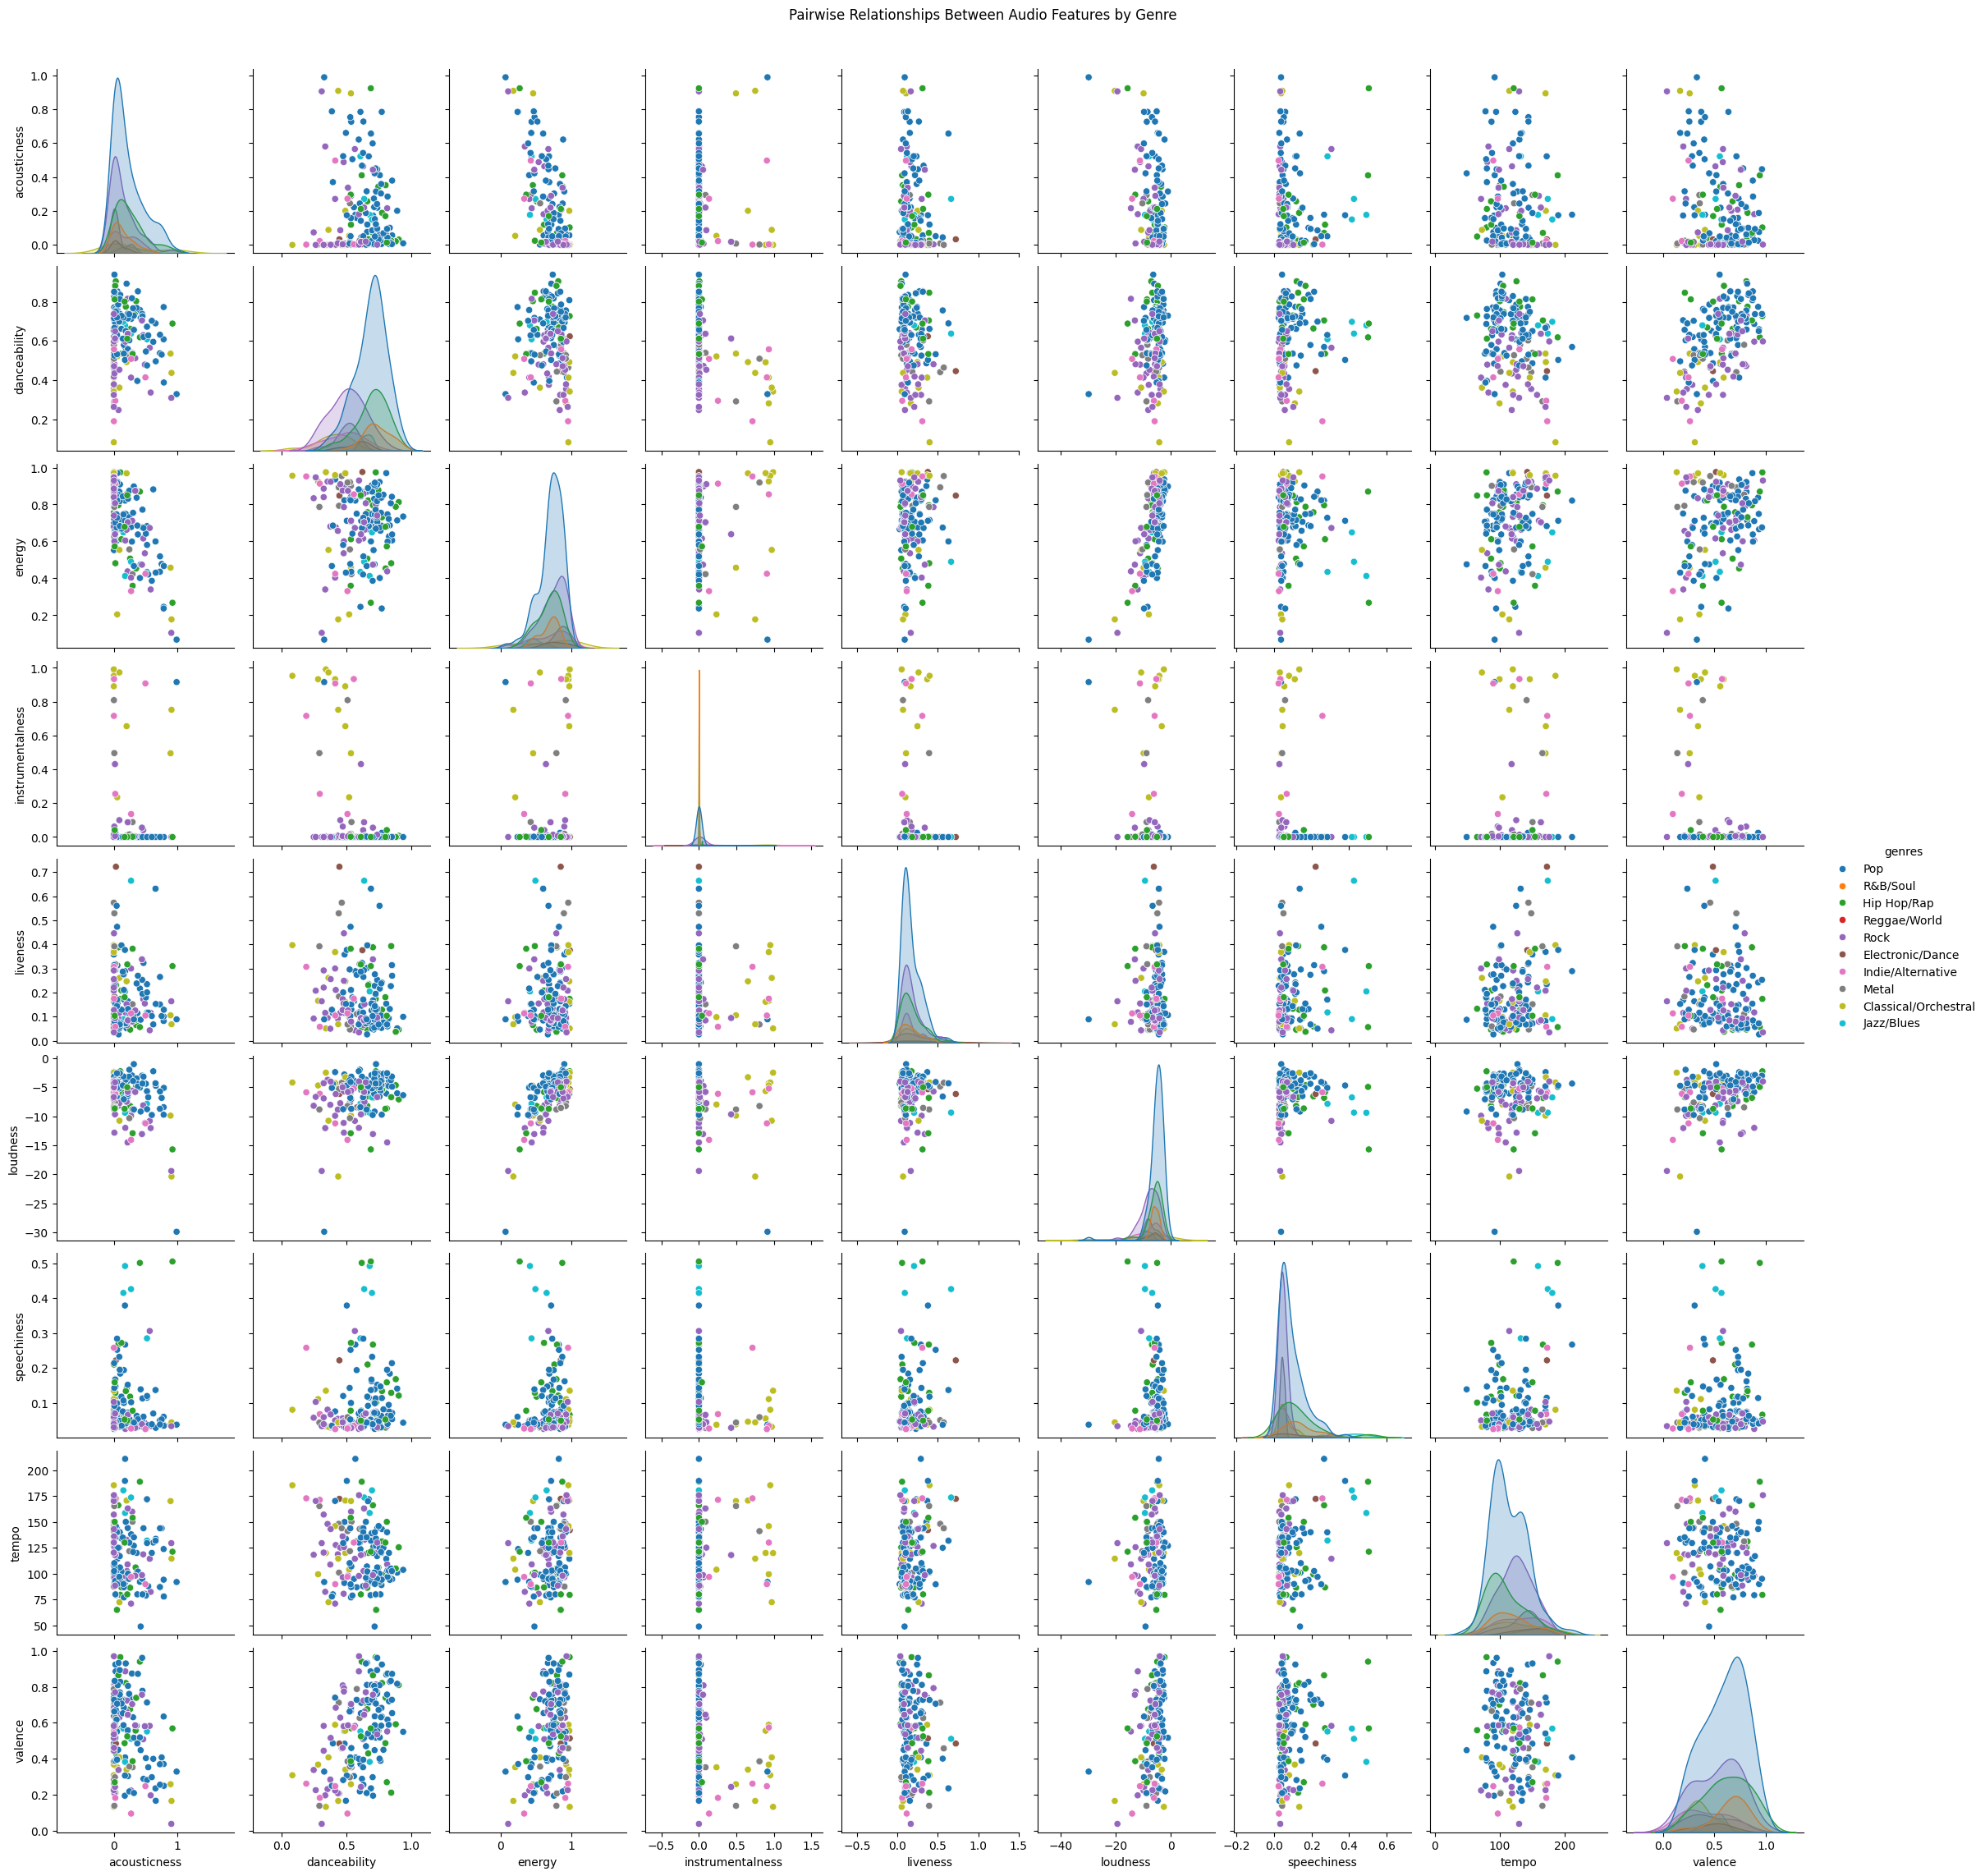

In [104]:
# Due to potentially many genres, it might be practical to limit pairplot to a subset of genres or to a random sample of data
subset_data = data_exploded[data_exploded['genres'].isin(categorization.keys())]

sns.pairplot(subset_data, hue='genres', vars=audio_features)
plt.suptitle('Pairwise Relationships Between Audio Features by Genre', y=1.02)
plt.show()

## Model Building

### MultiLabelBinarizer

Convert the list of genres into a format suitable for multi-label classification by using MultiLabelBinarizer. 

This is similar to one-hot encoding but specifically designed for lists of labels.

First we have to split the data into test adn train data to evalueate the model.

In [115]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Binarize the genres
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['genres'])

# Features (assuming they are the same as before)
X = data[audio_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.375
Hamming Loss: 0.08
Macro-average F1 score: 0.22910216718266252
Micro-average F1 score: 0.5555555555555556


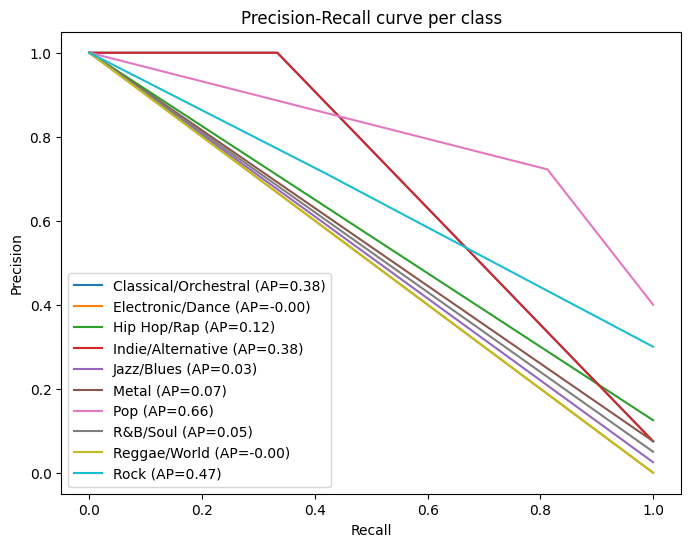

ROC AUC for class Classical/Orchestral: 0.67
ROC AUC for class Electronic/Dance: Not defined (only one class present)
ROC AUC for class Hip Hop/Rap: 0.50
ROC AUC for class Indie/Alternative: 0.67
ROC AUC for class Jazz/Blues: 0.50
ROC AUC for class Metal: 0.50
ROC AUC for class Pop: 0.80
ROC AUC for class R&B/Soul: 0.50
ROC AUC for class Reggae/World: Not defined (only one class present)
ROC AUC for class Rock: 0.67


In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve

# Initialize and train the model
model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Hamming Loss:", hamming_loss(y_test, y_pred))

# F1 Score
# Note: For a multi-label task, we need to specify the average parameter
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print(f'Macro-average F1 score: {f1_macro}')
print(f'Micro-average F1 score: {f1_micro}')

# Precision-Recall Curve and Average Precision
fig, ax = plt.subplots(figsize=(8, 6))
for i, genre in enumerate(mlb.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    ap = average_precision_score(y_test[:, i], y_pred[:, i])
    ax.plot(recall, precision, label=f'{genre} (AP={ap:.2f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve per class')
ax.legend(loc='best')
plt.show()

# Calculate ROC AUC score only for classes with both positive and negative instances
roc_auc_scores = {}
for i, class_name in enumerate(mlb.classes_):
    # Check if there is more than one class present
    if len(np.unique(y_test[:, i])) > 1:
        roc_auc_scores[class_name] = roc_auc_score(y_test[:, i], y_pred[:, i])
    else:
        roc_auc_scores[class_name] = None  # None if not applicable

# Print the ROC AUC scores for each class
for class_name, auc_score in roc_auc_scores.items():
    if auc_score is not None:
        print(f'ROC AUC for class {class_name}: {auc_score:.2f}')
    else:
        print(f'ROC AUC for class {class_name}: Not defined (only one class present)')

You can see that the above model has a very low performance with just 37.5% of the tracks in the test set had all their genre labels predicted correctly and the wrong label is predicted 8% of the time across all labels.

### Imbalance in Dataset

We saw earlier that the dataset contains imbalance in the distribution of tracks across various genres.

This imbalance indicates that if a classification model were trained on this dataset without addressing the imbalance, it might become biased toward predicting the more represented genres (such as Pop) over the less represented genres.

To counteract this, we can consider the following strategies:

1. Oversampling the minority classes: Increase the number of samples of the underrepresented genres in the dataset, either by duplicating existing samples or generating synthetic ones.
2. Undersampling the majority classes: Reduce the number of samples of the overrepresented genres, aiming for a more balanced dataset.
3. Weighted Loss Function: Assign a higher weight to the minority classes during the training of the model so that errors in predicting these classes have a greater impact on the learning process.

## Feature Selection

## Model Building

## Model Evaluation

## Model Optimization